# Data block API foundations

In [1]:
#!pip install torch
#!pip install conda
#!pip install matplotlib
#!pip install pandas
#!pip install image
#!pip install -U scikit-learn scipy
#!pip install category_encoders
#!pip install patsy

In [3]:
%load_ext autoreload
%autoreload 2


%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#https://xavierbourretsicotte.github.io/gaussian_mixture.html
#https://xavierbourretsicotte.github.io/gaussian_mixture.html
#notes

In [4]:

import torch
import torch.nn.functional as F
from torch.nn import init
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

import pandas as pd
import numpy as np

from pathlib import Path
from IPython.core.debugger import set_trace
import pickle, gzip, math, torch, matplotlib as mpl
from torch import tensor

from functools import partial
from typing import *
import re
import os
from collections import defaultdict

from sklearn.metrics import confusion_matrix
from scipy.stats import mode
from scipy.stats import multivariate_normal
#numeric encoding
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
from sklearn.preprocessing import LabelEncoder



#from cs229_main1 import *
#from cs229_labeler import *
#from cs229_model_gmm import *
from gmm import *




import matplotlib.pyplot as plt
from matplotlib import patches
import PIL,os,mimetypes
import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.set_num_threads(2)
#torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

from sklearn.mixture import GaussianMixture


print(os.listdir("./data/"))

['Small Training Set.csv', 'KDDTest+.csv', '20 Percent Training Set.csv', 'KDDTrain+_20Percent.txt', 'Original NSL KDD Zip.zip', 'KDDTrain+.txt', 'NSL_KDD-master', 'KDDTest-21.txt', 'KDDTest+.txt', 'Field Names.csv', 'NSL_KDD-master.zip', 'ReadMe.txt', 'cs229', 'Attack Types.csv', 'Field Names.docx', 'KDDTrain+.csv']


# Setup Get image files

In [5]:
#ls
Path.ls = lambda x: list(x.iterdir())

PATH = Path('./data/')
JPEGS = 'cs229'
IMG_PATH = PATH/JPEGS

#path = Path('../../../data/cs229/tmp')
path = Path('./data/cs229')
path.ls()

[PosixPath('data/cs229/test'),
 PosixPath('data/cs229/training_attack_types.txt'),
 PosixPath('data/cs229/train')]

In [6]:
path_train = path/'train'
path_test  = path/'test'
img_fn = path_train.ls()[0]
img_fn


PosixPath('data/cs229/train/training.csv')

In [7]:
traindata = pd.read_csv(path_train.ls()[0], header=None,names=['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','type','success_pred'])
testdata = pd.read_csv(path_test.ls()[0], header=None,names=['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','type','success_pred'])

#headers
traindata.head()
#one row
#traindata[1:1]


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type,success_pred
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [8]:
# 22  attach catagories
category = defaultdict(list)
category["benign"].append("normal")

# read the attacking mapping file
with open(path/'training_attack_types.txt', 'r') as f:
     for line in f.readlines():
         attack, cat = line.strip().split(' ')
         #print(attack, cat)
         category[cat].append(attack)
     
category

attack_mapping = dict((v,k) for k in category for v in category[k])

for k,v in attack_mapping.items():
     print(k,v)

normal benign
apache2 dos
back dos
mailbomb dos
processtable dos
snmpgetattack dos
teardrop dos
smurf dos
land dos
neptune dos
pod dos
udpstorm dos
ps u2r
buffer_overflow u2r
perl u2r
rootkit u2r
loadmodule u2r
xterm u2r
sqlattack u2r
httptunnel u2r
ftp_write r2l
guess_passwd r2l
snmpguess r2l
imap r2l
spy r2l
warezclient r2l
warezmaster r2l
multihop r2l
phf r2l
named r2l
sendmail r2l
xlock r2l
xsnoop r2l
worm probe
nmap probe
ipsweep probe
portsweep probe
satan probe
mscan probe
saint probe


In [9]:
#add a new column "attack_catagory"
traindata['attack_catagory'] = traindata['type'].map(lambda x: attack_mapping[x])
testdata['attack_catagory'] = testdata['type'].map(lambda x: attack_mapping[x])
testdata.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type,success_pred,attack_catagory
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,dos
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,dos
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21,benign
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15,probe
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11,probe


In [10]:
#traindata["type"].values
# traindata.loc[~traindata["type"].isin(["normal"]), 'type'] = 0
# traindata.loc[traindata["type"].isin(["normal"]), 'type'] = 1


In [11]:
count = traindata["type"].value_counts()
print(count)
print("anomoly percentage", count[0]/count.sum())

normal             13449
neptune             8282
ipsweep              710
satan                691
portsweep            587
smurf                529
nmap                 301
back                 196
teardrop             188
warezclient          181
pod                   38
guess_passwd          10
warezmaster            7
buffer_overflow        6
imap                   5
rootkit                4
phf                    2
multihop               2
land                   1
loadmodule             1
ftp_write              1
spy                    1
Name: type, dtype: int64
anomoly percentage 0.5338599555414417


In [12]:
# Differentiating between nominal, binary, and numeric features

# root_shell is marked as a continuous feature in the kddcup.names 
# file, but it is supposed to be a binary feature according to the 
# dataset documentation
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','type','success_pred']
col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

In [13]:
nominal_cols

['protocol_type', 'service', 'flag']

In [14]:
binary_cols

['land',
 'logged_in',
 'root_shell',
 'su_attempted',
 'is_host_login',
 'is_guest_login']

In [15]:
numeric_cols

['duration',
 'src_bytes',
 'dst_bytes',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'num_compromised',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']

In [16]:
# Let's take a look at the binary features
# By definition, all of these features should have a min of 0.0 and a max of 1.0

traindata[binary_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
land,25192.0,0.000079,0.008910,0.0,0.0,0.0,0.0,1.0
logged_in,25192.0,0.394768,0.488811,0.0,0.0,0.0,1.0,1.0
root_shell,25192.0,0.001548,0.039316,0.0,0.0,0.0,0.0,1.0
su_attempted,25192.0,0.001350,0.048785,0.0,0.0,0.0,0.0,2.0
is_host_login,25192.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
is_guest_login,25192.0,0.009130,0.095115,0.0,0.0,0.0,0.0,1.0


In [17]:
#  the su_attempted column has a max value of 2.0?

traindata.groupby(['su_attempted']).size()

su_attempted
0    25171
1        8
2       13
dtype: int64

In [18]:
# Let's fix this discrepancy and assume that su_attempted=2 -> su_attempted=0

traindata['su_attempted'].replace(2, 0, inplace=True)
testdata['su_attempted'].replace(2, 0, inplace=True)
traindata.groupby(['su_attempted']).size()

su_attempted
0    25184
1        8
dtype: int64

In [19]:
# Next, we notice that the num_outbound_cmds column only takes on one value!

traindata.groupby(['num_outbound_cmds']).size()

num_outbound_cmds
0    25192
dtype: int64

In [20]:
# Now, that's not a very useful feature - let's drop it from the dataset

traindata.drop('num_outbound_cmds', axis = 1, inplace=True)
testdata.drop('num_outbound_cmds', axis = 1, inplace=True)
numeric_cols.remove('num_outbound_cmds')

Data Preparation

In [21]:
train_Y = traindata['attack_catagory']
train_x_raw = traindata.drop(['attack_catagory','type'], axis=1)
test_Y = testdata['attack_catagory']
test_x_raw = testdata.drop(['attack_catagory','type'], axis=1)
train_Y.head()


0    benign
1    benign
2       dos
3    benign
4    benign
Name: attack_catagory, dtype: object

In [22]:
target_names = train_Y.unique()
print(target_names)

['benign' 'dos' 'r2l' 'probe' 'u2r']


In [23]:
num_classes = len(np.unique(train_Y))
num_classes

5

In [24]:

combined_df_raw = pd.concat([train_x_raw, test_x_raw])

combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]
# Store dummy variable feature names
dummy_variables = list(set(train_x)-set(combined_df_raw))

In [25]:
test_x.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2,12983,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,20,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,15,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [26]:
train_x['duration'].describe()

count    25192.000000
mean       305.054104
std       2686.555640
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      42862.000000
Name: duration, dtype: float64

In [27]:
# Experimenting with StandardScaler on the single 'duration' feature
from sklearn.preprocessing import StandardScaler

durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

count    2.519200e+04
mean     1.424357e-17
std      1.000020e+00
min     -1.135507e-01
25%     -1.135507e-01
50%     -1.135507e-01
75%     -1.135507e-01
max      1.584102e+01
dtype: float64

In [28]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()

count    25192.000000
mean         0.007117
std          0.062679
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
dtype: float64

In [29]:
from sklearn.preprocessing import RobustScaler

min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

count    25192.000000
mean       305.054104
std       2686.555640
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      42862.000000
dtype: float64

In [30]:
# Let's proceed with StandardScaler- Apply to all the numeric columns

standard_scaler = StandardScaler().fit(train_x[numeric_cols])

train_x[numeric_cols] = \
    standard_scaler.transform(train_x[numeric_cols])

test_x[numeric_cols] = \
    standard_scaler.transform(test_x[numeric_cols])

/Users/suvasismukherjee/ipy-jupyter-venv3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/suvasismukherjee/ipy-jupyter-venv3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/suvasismukherjee/ipy-jupyter-venv3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [31]:
train_x.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,2.519200e+04,2.519200e+04,2.519200e+04,25192.000000,2.519200e+04,2.519200e+04,2.519200e+04,2.519200e+04,25192.000000,2.519200e+04,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,1.424357e-17,1.410255e-19,-5.641019e-19,0.000079,-1.579485e-17,3.878200e-19,2.242305e-17,-1.099999e-17,0.394768,8.955117e-18,...,0.087964,0.012067,0.000834,0.019728,0.278223,0.003493,0.000834,0.000595,0.594355,0.001707
std,1.000020e+00,1.000020e+00,1.000020e+00,0.008910,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,0.488811,1.000020e+00,...,0.283249,0.109189,0.028861,0.139068,0.448133,0.059001,0.028861,0.024395,0.491026,0.041280
min,-1.135507e-01,-1.009252e-02,-3.930979e-02,0.000000,-9.122318e-02,-6.300533e-03,-9.193335e-02,-2.622029e-02,0.000000,-2.187261e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.135507e-01,-1.009252e-02,-3.930979e-02,0.000000,-9.122318e-02,-6.300533e-03,-9.193335e-02,-2.622029e-02,0.000000,-2.187261e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.135507e-01,-1.007427e-02,-3.930979e-02,0.000000,-9.122318e-02,-6.300533e-03,-9.193335e-02,-2.622029e-02,0.000000,-2.187261e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,-1.135507e-01,-9.976793e-03,-3.334045e-02,0.000000,-9.122318e-02,-6.300533e-03,-9.193335e-02,-2.622029e-02,1.000000,-2.187261e-02,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.584102e+01,1.583257e+02,5.795287e+01,1.000000,1.143768e+01,1.587167e+02,3.565287e+01,8.804599e+01,1.000000,8.483823e+01,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
train_x.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-0.113551,-0.009889,-0.039310,0,-0.091223,-0.006301,-0.091933,-0.02622,0,-0.021873,...,0,0,0,0,0,0,0,0,1,0
1,-0.113551,-0.010032,-0.039310,0,-0.091223,-0.006301,-0.091933,-0.02622,0,-0.021873,...,0,0,0,0,0,0,0,0,1,0
2,-0.113551,-0.010093,-0.039310,0,-0.091223,-0.006301,-0.091933,-0.02622,0,-0.021873,...,0,0,0,0,1,0,0,0,0,0
3,-0.113551,-0.009996,0.052473,0,-0.091223,-0.006301,-0.091933,-0.02622,1,-0.021873,...,0,0,0,0,0,0,0,0,1,0
4,-0.113551,-0.010010,-0.034582,0,-0.091223,-0.006301,-0.091933,-0.02622,1,-0.021873,...,0,0,0,0,0,0,0,0,1,0


In [33]:
#stanford gmm

Attempting unsupervised learning

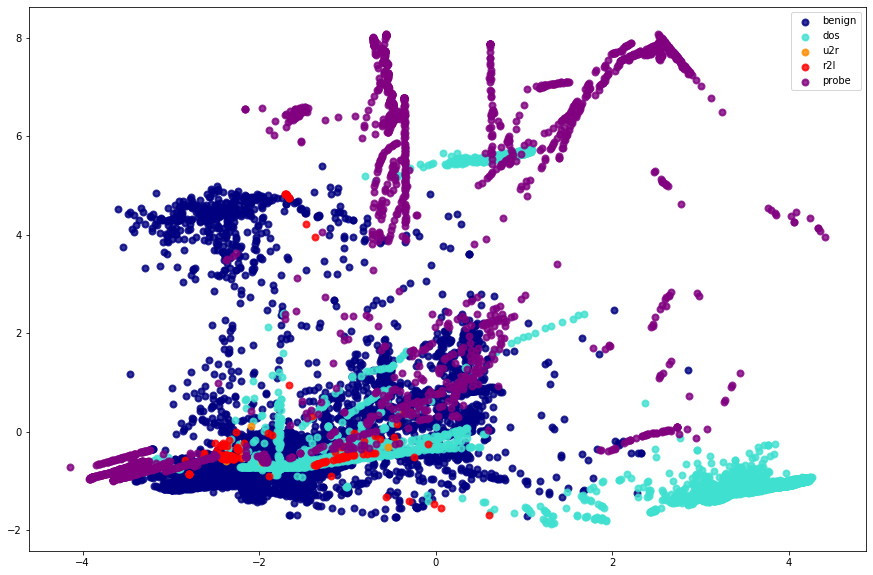

In [34]:
# First, let's visualize the dataset (only numeric cols)

from sklearn.decomposition import PCA

# Use PCA to reduce dimensionality so we can visualize the dataset on a 2d plot
# check this  https://github.com/ggulgun/NIDS-Intrusion-Detection/blob/master/IDS.py
pca = PCA(n_components=7)
train_x_pca_cont = pca.fit_transform(train_x[numeric_cols])

plt.figure(figsize=(15,10))
colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple']

for color, cat in zip(colors, category.keys()):
    plt.scatter(train_x_pca_cont[train_Y==cat, 0], train_x_pca_cont[train_Y==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

In [35]:
train_x_pca_cont = train_x_pca_cont[:1000]
print(train_x_pca_cont.shape)

(1000, 7)


In [36]:
train_Y.head()

0    benign
1    benign
2       dos
3    benign
4    benign
Name: attack_catagory, dtype: object

In [37]:
# Let's create an object of the class LabelEncoder

le = LabelEncoder()
#print(train_Y.astype(str))
le.fit(train_Y.astype(str))
train_Y_trans = le.transform(train_Y.astype(str))
#print(le)
# for i in range(len(train_Y_trans)):
#     if train_Y_trans[i] == 4:
#         print("yes")


print(len(train_Y_trans))
#train_Y.head()

25192


In [38]:
train_Y_trans_semiss = train_Y_trans[:1000]

train_Y_trans_semiss[train_Y_trans_semiss >= 0] = -1

# 1
# 1
# 0
# 0
# 1
# 0
# 2
train_Y_trans_semiss[10]=1
train_Y_trans_semiss[104]=1
train_Y_trans_semiss[521]=0
train_Y_trans_semiss[639]=0
train_Y_trans_semiss[710]=1
train_Y_trans_semiss[890]=0
train_Y_trans_semiss[992]=2

# print(train_Y_trans_semiss[10])
# print(train_Y_trans_semiss[104])
# print(train_Y_trans_semiss[521])
# print(train_Y_trans_semiss[639])
# print(train_Y_trans_semiss[710])
# print(train_Y_trans_semiss[890])
# print(train_Y_trans_semiss[992])





In [39]:
# A = np.random.normal(size=(5,2))
# A

# # add a column of zeros to it:
# print(np.hstack((A,np.zeros((A.shape[0],1)))))
#train_x_pca_cont[:1000].shape
train_Y_trans_semiss.shape

all_data = np.column_stack((train_x_pca_cont[:1000], np.array(train_Y_trans_semiss, dtype='int32')))
print(all_data[10])
print(all_data.shape)
print(train_Y_trans_semiss.shape)

[ 0.85510442  5.62699124 -0.22202188 -1.15192503 -1.21104833 -1.22538632
  0.57801339  1.        ]
(1000, 8)
(1000,)


In [40]:


#train_Y_trans_semiss
UNLABELED = -1  # Cluster label for unlabeled data points (do not change)
# # Split into labeled and unlabeled examples
labeled_idxs = (train_Y_trans_semiss != UNLABELED).squeeze()
#print(labeled_idxs)

x_tilde = all_data[labeled_idxs, :]   # Labeled examples
x_tilde = x_tilde[:,:-1]
print(x_tilde)
# #check
z_tilde = all_data[labeled_idxs,:]   # Corresponding labels
#print(z_tilde.shape)
z_tilde = z_tilde[:,-1]
print(z_tilde)
x = all_data[~labeled_idxs, :]        # Unlabeled examples
x.shape

[[ 0.85510442  5.62699124 -0.22202188 -1.15192503 -1.21104833 -1.22538632
   0.57801339]
 [-1.51542664  0.10902606 -0.10975507 -0.719664    3.65377627  2.79058379
  -1.59134625]
 [-2.53236064 -1.05868872 -0.09375094  0.09157178 -0.68715874 -0.24077065
  -0.09393033]
 [-1.94878548 -0.96385244 -0.1146629  -1.01624082 -0.4676843   0.24315726
  -0.1010145 ]
 [ 0.60183811  5.53399531 -0.21054372 -0.99524933 -1.52977172 -1.0055397
   0.52671928]
 [-1.44022562 -0.53504456 -0.02119733  0.07591473 -0.48163262  0.65109212
  -0.25911123]
 [-0.47163967  6.44802979 -0.03869243  1.10741436  1.03346142  0.61505939
   0.43429263]]
[1. 1. 0. 0. 1. 0. 2.]


(993, 8)

In [41]:
n,d = x.shape
print(n,d)
x = x[:,:-1]
x.shape

993 8


(993, 7)

In [42]:
# *** START CODE HERE ***
# (1) Initialize mu and sigma by splitting the n_examples data points uniformly at random
K=12
# x instead of train_x_pca_cont already processed
#train_x_pca_cont = train_x_pca_cont[:1000]
n,d = x.shape
print(n,d)
group = np.random.choice(K, n)
mu = [np.mean(x[group == g, :], axis=0) for g in range(K)]
sigma = [np.cov(x[group == g, :].T) for g in range(K)]
print("mu",mu)
print("sigma",sigma)



# into K groups, then calculating the sample mean and covariance for each group
# (2) Initialize phi to place equal probability on each Gaussian
# phi should be a numpy array of shape (K,)
phi = np.full((K,), fill_value=(1. / K), dtype=np.float32)
print("phi",phi)

993 7
mu [array([ 0.52373913, -0.30156886, -0.04337666,  0.12964738,  0.00810054,
       -0.10406318, -0.03127579]), array([ 0.45353496, -0.04056773, -0.03813682,  0.29980607,  0.17911683,
       -0.01691552, -0.09250413]), array([-0.2796803 ,  0.16205596,  0.01648412, -0.15398687, -0.21876082,
        0.00453392,  0.10797712]), array([ 0.25853724,  0.11169903,  0.03629132, -0.09851339,  0.03441915,
       -0.25685095,  0.01806717]), array([-0.20461804,  0.06388897, -0.04204523,  0.28743352, -0.27171386,
       -0.01055017, -0.1032016 ]), array([-0.01798654, -0.06552479, -0.06151228, -0.07836146, -0.27313045,
        0.03190339, -0.08126015]), array([ 0.1081657 ,  0.5574293 ,  0.01758128, -0.01974406, -0.023117  ,
        0.23960704, -0.05624642]), array([ 0.18900789, -0.25251189, -0.05812363,  0.03616857, -0.19524807,
       -0.19888002, -0.09107589]), array([-0.25209204,  0.1664117 , -0.04708398,  0.07794545,  0.00085989,
        0.04152915, -0.04582044]), array([ 0.25187453, -0.1704

In [43]:

#http://www.oranlooney.com/post/ml-from-scratch-part-5-gmm/
def plot_axis_pairs(X, axis_pairs, clusters, classes):
    n_rows = len(axis_pairs) // 2
    n_cols = 2
    plt.figure(figsize=(16, 10))
    for index, (x_axis, y_axis) in enumerate(axis_pairs):
        plt.subplot(n_rows, n_cols, index+1)
        plt.title('GMM Clusters')
        plt.xlabel(train_x_pca_cont[x_axis])
        plt.ylabel(train_x_pca_cont[y_axis])
        plt.scatter(
            jitter(X[:, x_axis]), 
            jitter(X[:, y_axis]), 
            #c=clusters, 
            cmap=plt.cm.get_cmap('brg'),
            marker='x')
    plt.tight_layout()
    
def jitter(x):
    return x + np.random.uniform(low=-0.05, high=0.05, size=x.shape)

In [44]:
exll = []
exll.append((1,2.2))
exll.append((2,3.1))

print(exll)

for items in exll:
    itr,ll = items
    print(itr, " m ")

[(1, 2.2), (2, 3.1)]
1  m 
2  m 


w [[0.08333334 0.08333334 0.08333334 ... 0.08333334 0.08333334 0.08333334]
 [0.08333334 0.08333334 0.08333334 ... 0.08333334 0.08333334 0.08333334]
 [0.08333334 0.08333334 0.08333334 ... 0.08333334 0.08333334 0.08333334]
 ...
 [0.08333334 0.08333334 0.08333334 ... 0.08333334 0.08333334 0.08333334]
 [0.08333334 0.08333334 0.08333334 ... 0.08333334 0.08333334 0.08333334]
 [0.08333334 0.08333334 0.08333334 ... 0.08333334 0.08333334 0.08333334]]
e-step m,n 993 7
w in e-step (993, 12)
ll from log-like -4319.377402185546
ll from log-like -22.892422885161153
[iter: 001, log-likelihood: -5463.9985]
e-step m,n 993 7
w in e-step (993, 12)
ll from log-like -1469.7886225807938
ll from log-like 15.1910240740026
[iter: 002, log-likelihood: -710.2374]
e-step m,n 993 7
w in e-step (993, 12)
ll from log-like -248.9594964910722
ll from log-like 45.652166658332405
[iter: 003, log-likelihood: 2033.6488]
e-step m,n 993 7
w in e-step (993, 12)
ll from log-like 1547.4911463799383
ll from log-like 54.29174271

w in e-step (993, 12)
ll from log-like 6328.196978677408
ll from log-like 129.21096558386665
[iter: 053, log-likelihood: 12788.7453]
e-step m,n 993 7
w in e-step (993, 12)
ll from log-like 6328.202856017927
ll from log-like 129.2109270973293
[iter: 054, log-likelihood: 12788.7492]
e-step m,n 993 7
w in e-step (993, 12)
ll from log-like 6328.2087106110475
ll from log-like 129.2108666448863
[iter: 055, log-likelihood: 12788.7520]
e-step m,n 993 7
w in e-step (993, 12)
ll from log-like 6328.212142306961
ll from log-like 129.21083338610373
[iter: 056, log-likelihood: 12788.7538]
e-step m,n 993 7
w in e-step (993, 12)
ll from log-like 6328.21564072892
ll from log-like 129.2107887238859
[iter: 057, log-likelihood: 12788.7551]
e-step m,n 993 7
w in e-step (993, 12)
ll from log-like 6328.217917095563
ll from log-like 129.21075775261147
[iter: 058, log-likelihood: 12788.7558]
w after em [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  2.2818634e-02 4.2495070e-04]
 [0.0000000e+00 

/Users/suvasismukherjee/ipy-jupyter-venv3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/Users/suvasismukherjee/ipy-jupyter-venv3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
/Users/suvasismukherjee/ipy-jupyter-venv3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

/Users/suvasismukherjee/ipy-jupyter-venv3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/Users/suvasismukherjee/ipy-jupyter-venv3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide
/Users/suvasismukherjee/ipy-jupyter-venv3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide


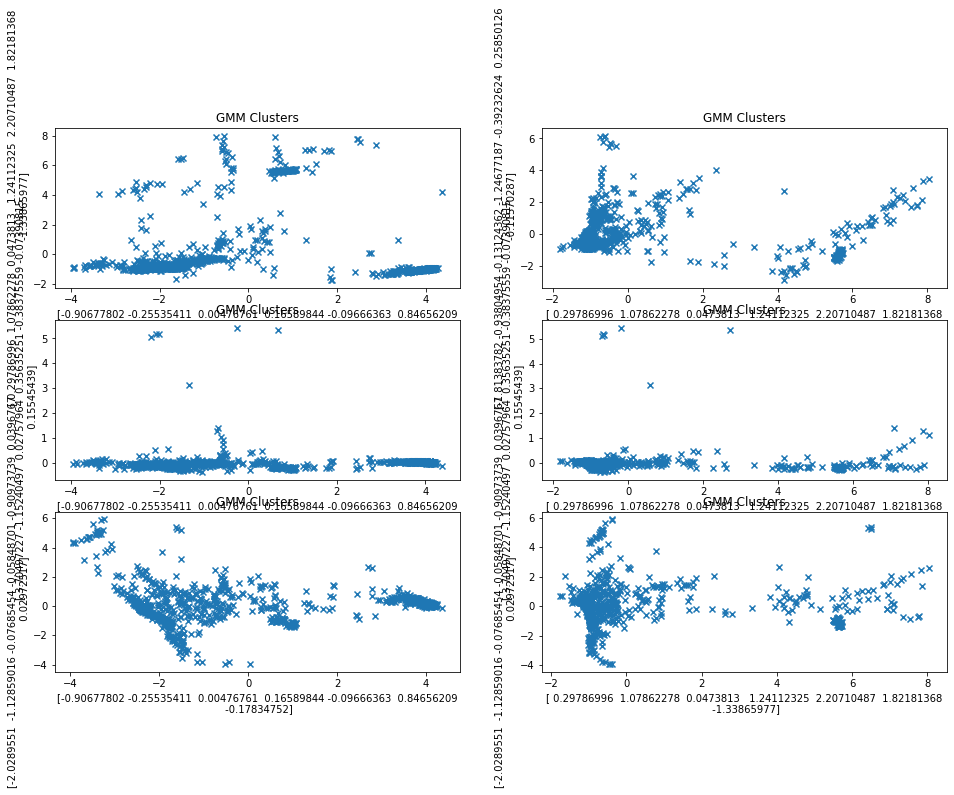

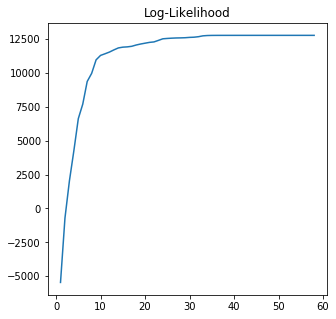

In [45]:


# (3) Initialize the w values to place equal probability on each Gaussian
# w should be a numpy array of shape (m, K)

w = np.full((n, K), fill_value=(1. / K), dtype=np.float32)
print("w",w)


# *** END CODE HERE ***

is_semi_supervised=True
if is_semi_supervised:
    w, iteration_ll = run_semi_supervised_em(x, x_tilde, z_tilde, w, phi, mu, sigma)
# else:
#w, iteration_ll = run_em(x, w, phi, mu, sigma)
print("w after em",w)
# Plot your predictions
z_pred = np.zeros(n)
if w is not None:  # Just a placeholder for the starter code
    for i in range(n):
        z_pred[i] = np.argmax(w[i])
is_semi_supervised=True
trial_num=10
#plot_gmm_preds(train_x_pca_cont, z_pred, is_semi_supervised, plot_id=trial_num)
print(z_pred)
plot_axis_pairs(
    X=train_x_pca_cont,
    axis_pairs=[ 
        (0,1), (1,4), 
        (0,2), (1,2),
        (0,3), (1,3)],
    clusters=z_pred,
    classes=["0","1","2","3","4"])

permutation = np.array([
    mode(train_Y_trans[:993][z_pred == i]).mode.item() 
    for i in range(K)])
permuted_prediction = permutation[z_pred.astype(int)]
print(permuted_prediction)
print(np.mean(train_Y_trans[:993] == permuted_prediction))

#https://towardsdatascience.com/decoding-the-confusion-matrix-bb4801decbb
print("confusion matrix start")
confusion_matrix1 = confusion_matrix(train_Y_trans[:993], permuted_prediction)
print(confusion_matrix(train_Y_trans[:993], permuted_prediction))
print("confusion matrix end")
from sklearn.metrics import classification_report

print(classification_report(train_Y_trans[:993], permuted_prediction))
from sklearn.metrics import accuracy_score
print ('Accuracy Score :',accuracy_score(train_Y_trans[:993], permuted_prediction))

FP = confusion_matrix1.sum(axis=0) - np.diag(confusion_matrix1)  
FN = confusion_matrix1.sum(axis=1) - np.diag(confusion_matrix1)
TP = np.diag(confusion_matrix1)
TN = confusion_matrix1[:].sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("detection rate: ",PPV)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print(ACC)

#http://www.oranlooney.com/post/ml-from-scratch-part-5-gmm/

# permutation = np.array([
#     mode(train_Y_trans[:1000][z_pred == i]).mode.item() 
#     for i in range(5)])
# permuted_prediction = permutation[z_pred.astype(int)]
# print(permuted_prediction)
# print(np.mean(train_Y_trans[:1000] == permuted_prediction))
# confusion_matrix(train_Y_trans[:1000], permuted_prediction)

# permutation = np.array([
#     mode(x[:,-1][z_pred == i]).mode.item() 
#     for i in range(K)])
# permuted_prediction = permutation[z_pred.astype(int)]
# print(permuted_prediction)
# print(np.mean(x[:,-1] == permuted_prediction))
# confusion_matrix(x[:,-1], permuted_prediction)



#plot of ll and iteration
itrs = []
lls = []
for items in iteration_ll:
    itr, logl = items
    itrs.append(itr)
    lls.append(logl)

plt.figure(figsize=(5, 5))
plt.title('Log-Likelihood')
#plt.plot(np.arange(1, n_epochs + 1), likelihoods)
plt.plot(np.arange(1, len(itrs) + 1), lls)
plt.show()

##how to get mu and sigma? for histogram plot
# import seaborn as sns
# n = 10000 # number of sample to be drawn
# mu = [-6, 5]
# sigma = [2, 3]
# samples = []
# for i in range(n): # iteratively draw samples
#     Z = np.random.choice([0,1]) # latent variable
#     samples.append(np.random.normal(mu[Z], sigma[Z], 1))
# sns.distplot(samples, hist=False)
# plt.show()
# sns.distplot(samples)
# plt.show()

# THE END